In [1]:
# import modules

import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from geopy.distance import vincenty
import re
import statsmodels.formula.api as sm
from scipy.stats import gaussian_kde
%pylab inline

# load yelp API

from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

# read API keys
with open('config_secret.json') as cred:
    creds = json.load(cred)
    auth = Oauth1Authenticator(**creds)
    client = Client(auth)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read yelp data from file

yelpdf = pd.read_csv('yelpdf.csv', index_col=0)

In [3]:
# read NYC felonies data from file

crimedf = pd.read_csv('NYPD_7_Major_Felony_Incident_Map.csv', index_col=0)

In [4]:
# use only 2015 incidents

crimedf2015=crimedf[crimedf['Occurrence Year']==2015]

In [5]:
# convert crime dataframe text lat/long coordinates to float tuples. 
# need to split the string into the lat and long numbers, convert into floats and then combine them into tuples.

tupler = lambda x: tuple(map(float, str.split(x[1:-1], sep=',')))

crimedf2015['lat_long']=crimedf2015['Location 1'].apply(tupler)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# create float tuple coordinates from yelp latitude, longitude data

yelpdf['lat_long'] = yelpdf[['latitude', 'longitude']].apply(tuple, axis=1)

In [7]:
# define distance calculation function using Vincenty's formula from lat/long pairs

def dist_calc(pointA, pointB):
    return vincenty(pointA, pointB).miles

In [8]:
# crime filter: for any given point, return the list of felony IDs within the threshold

def crime_list(pointA, crimetable, threshold=0.25):
    list_of_distances=[]
    df=crimetable
    for crimeloc in df.lat_long:
        list_of_distances.append(dist_calc(pointA, crimeloc))
    df_of_crimes=pd.DataFrame({'Identifier':df.Identifier, 'Offense':df.Offense,'Distance':list_of_distances })
    return df_of_crimes[df_of_crimes.Distance<threshold]

In [9]:
# read combined yelp and crime data csv

yelpcrimedf = pd.read_csv('yelpcrimedf.csv', index_col=0)

In [10]:
# abbreviate crime names

felonyfull=list(yelpcrimedf.columns[-7:])
felonyabbrv=['BUR','ASS','LAR','GTA','MUR','RAP','ROB']
felony_ref=pd.DataFrame({'code':felonyabbrv, 'full_name':felonyfull})
print(felony_ref)

  code                       full_name
0  BUR                        BURGLARY
1  ASS                  FELONY ASSAULT
2  LAR                   GRAND LARCENY
3  GTA  GRAND LARCENY OF MOTOR VEHICLE
4  MUR  MURDER & NON-NEGL. MANSLAUGHTE
5  RAP                            RAPE
6  ROB                         ROBBERY


In [11]:
# rename crime columns with 3 letter code

yelpcrimedf.rename(columns=dict(zip(felony_ref.full_name, felony_ref.code)), inplace=True)

In [12]:
# sum of felonies by business

yelpcrimedf['TOT']=yelpcrimedf[felonyabbrv].sum(axis=1)

In [13]:
# breakdown of crime by type
felname=[]
felcount=[]
for felony in felony_ref.full_name:
    felname.append(felony_ref.code[felony_ref.full_name==felony].values[0])
    felcount.append(sum(crimedf2015.Offense==felony))

feltable=pd.DataFrame({'felony':felname, 'number_of_felonies': felcount})

In [15]:
yelpcrimedf.head()

,categories,deals,display_phone,distance,eat24_url,gift_certificates,id,image_url,is_claimed,is_closed,...,longitude,lat_long,BUR,ASS,LAR,GTA,MUR,RAP,ROB,TOT
0,"[Category(name='American (New)', alias='newame...",NaN,+1-212-866-7200,NaN,NaN,NaN,the-hamilton-new-york-3,https://s3-media2.fl.yelpcdn.com/bphoto/n2Mypb...,True,False,...,-73.964021,"(40.802766878663199, -73.964021420623794)",32,21,109,1,0,0,33,196
1,"[Category(name='Bars', alias='bars')]",NaN,+1-212-586-2707,NaN,NaN,NaN,the-pony-bar-new-york,https://s3-media4.fl.yelpcdn.com/bphoto/QKa1Hz...,True,False,...,-73.994310,"(40.761780000000002, -73.994309999999999)",32,40,178,8,0,0,28,286
2,"[Category(name='Cocktail Bars', alias='cocktai...",NaN,+1-646-918-6923,NaN,NaN,NaN,dutch-freds-new-york-2,https://s3-media2.fl.yelpcdn.com/bphoto/78gMj-...,True,False,...,-73.987846,"(40.760818481445298, -73.987846374511705)",59,61,449,8,1,0,68,646
3,"[Category(name='Bars', alias='bars')]",NaN,+1-212-877-0961,NaN,NaN,NaN,es-bar-new-york,https://s3-media1.fl.yelpcdn.com/bphoto/s_n3rI...,True,False,...,-73.975565,"(40.786692073144998, -73.975565358996406)",18,23,162,7,0,6,22,238
4,"[Category(name='Cocktail Bars', alias='cocktai...",NaN,+1-646-590-2034,NaN,NaN,NaN,tanner-smiths-new-york,https://s3-media2.fl.yelpcdn.com/bphoto/R3F_aR...,True,False,...,-73.981712,"(40.764278000000004, -73.981712000000002)",45,36,275,11,0,10,37,414


In [16]:
feltable['pct']=feltable.number_of_felonies/sum(feltable.number_of_felonies)

feltable=feltable.sort('number_of_felonies', ascending=False)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [20]:
sum(feltable.number_of_felonies)

26035

,felony,number_of_felonies,pct
2,LAR,15545,0.597081
1,ASS,3533,0.135702
6,ROB,3135,0.120415
0,BUR,2737,0.105128
3,GTA,799,0.030689
5,RAP,247,0.009487
4,MUR,39,0.001498


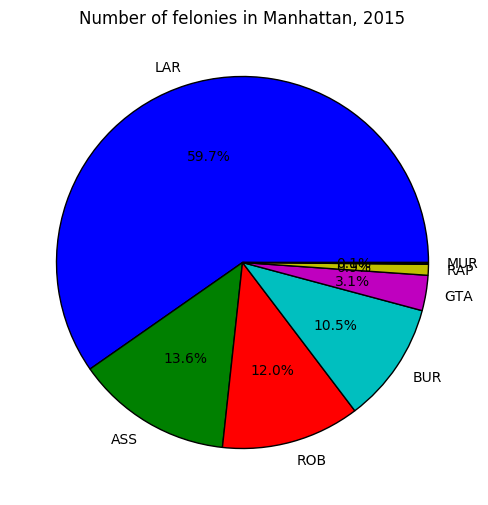

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Number of felonies in Manhattan, 2015')
P=ax.pie(feltable.number_of_felonies, labels=list(feltable.felony), autopct='%1.1f%%')
feltable

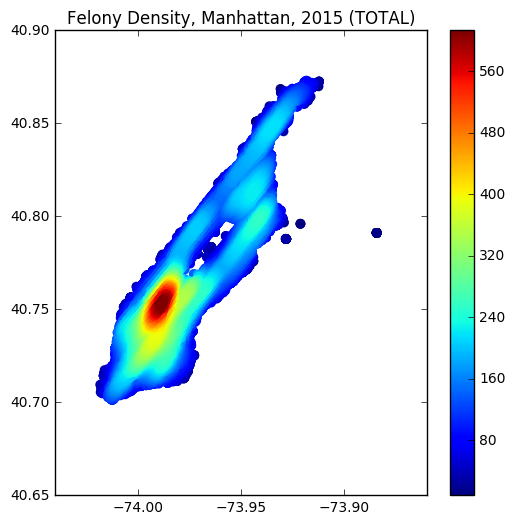

In [25]:
#KDE for all felonies

x,y = zip(*crimedf2015.lat_long)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x = np.array(x)
y = np.array(y)
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Felony Density, Manhattan, 2015 (TOTAL)')
cax=ax.scatter(y, x, c=z, s=50, edgecolor='')
fig.colorbar(cax)

plt.show()


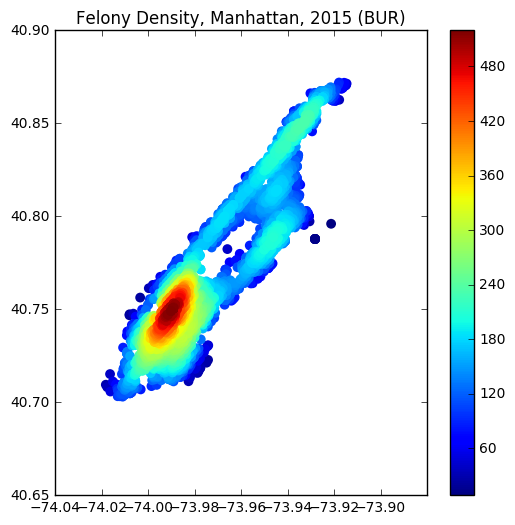

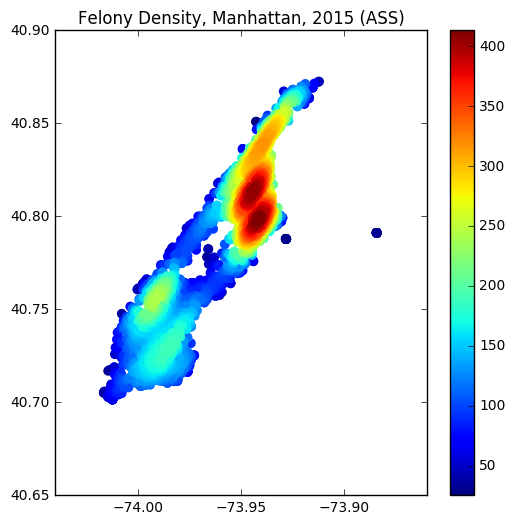

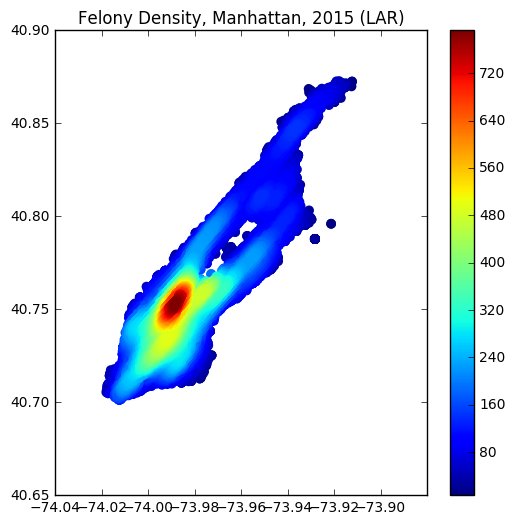

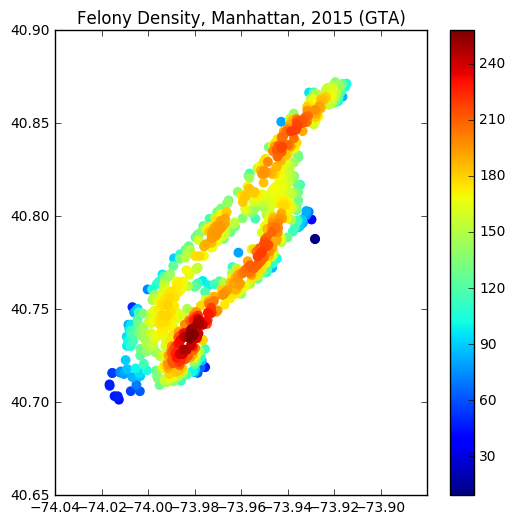

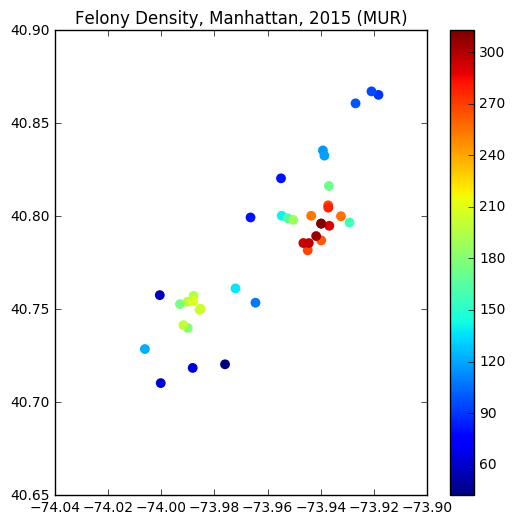

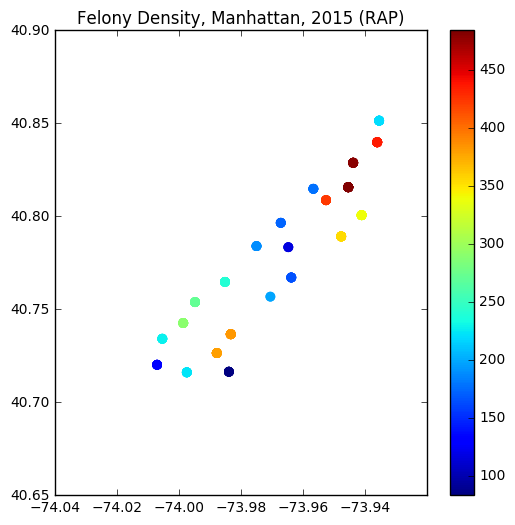

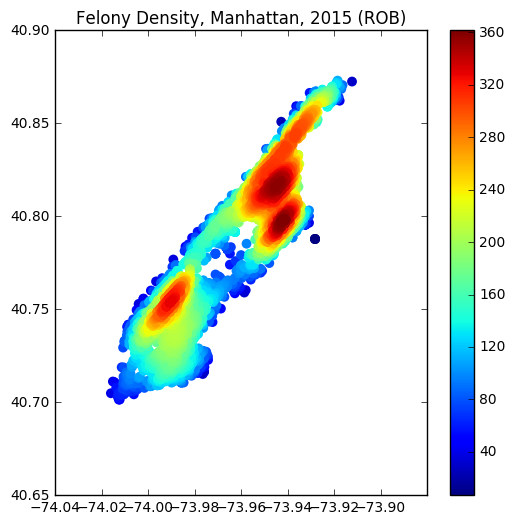

In [26]:
# KDE for felony by type of felony

for ref in felony_ref.code:
    x,y = zip(*crimedf2015.lat_long[crimedf2015.Offense==list(felony_ref.full_name[felony_ref.code==ref])[0]])
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x = np.array(x)
    y = np.array(y)
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title('Felony Density, Manhattan, 2015 (' + ref +')')
    cax=ax.scatter(y, x, c=z, s=50, edgecolor='')
    fig.colorbar(cax)

    plt.show()
    
    

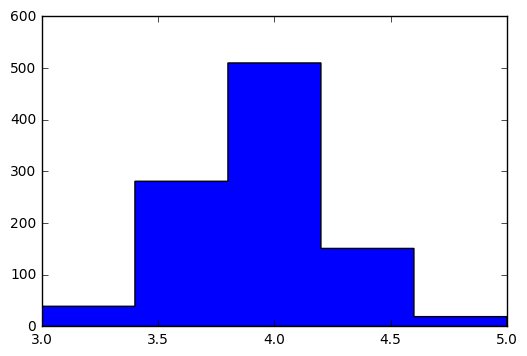

In [28]:
# histogram of ratings

fig, ax = plt.subplots()

H = ax.hist(yelpcrimedf['rating'], bins=5, histtype='stepfilled')

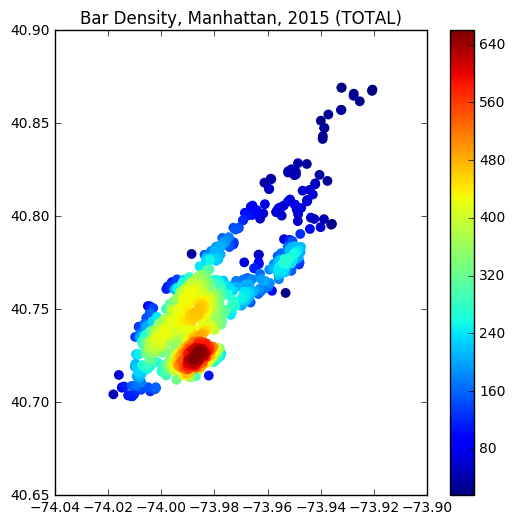

In [29]:
# KDE for bar density

x,y = zip(*yelpdf.lat_long)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x = np.array(x)
y = np.array(y)
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Bar Density, Manhattan, 2015 (TOTAL)')
cax=ax.scatter(y, x, c=z, s=50, edgecolor='')
fig.colorbar(cax)

plt.show()

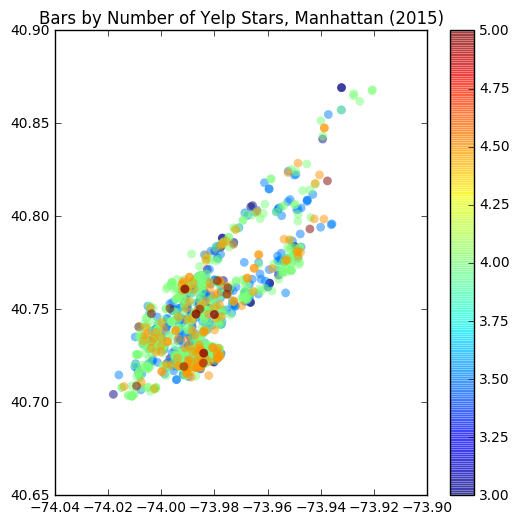

In [32]:
# Colormap for yelp stars

x,y = zip(*yelpdf.lat_long)
z = yelpdf.rating

idx = z.argsort()
x = np.array(x)
y = np.array(y)
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Bars by Number of Yelp Stars, Manhattan (2015)')
cax=ax.scatter(y, x, c=z, s=40, alpha=0.5, edgecolor='')
fig.colorbar(cax)
plt.show()

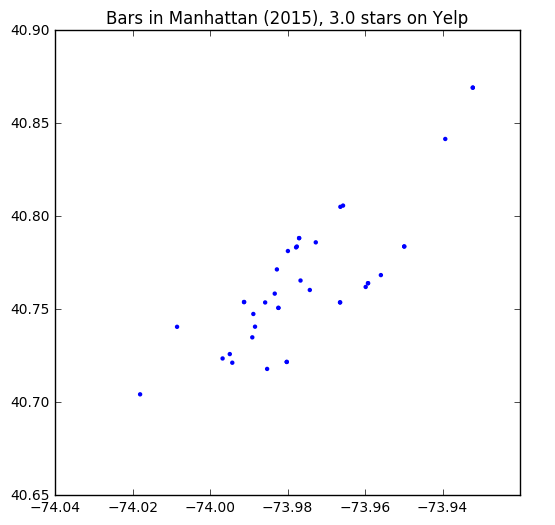

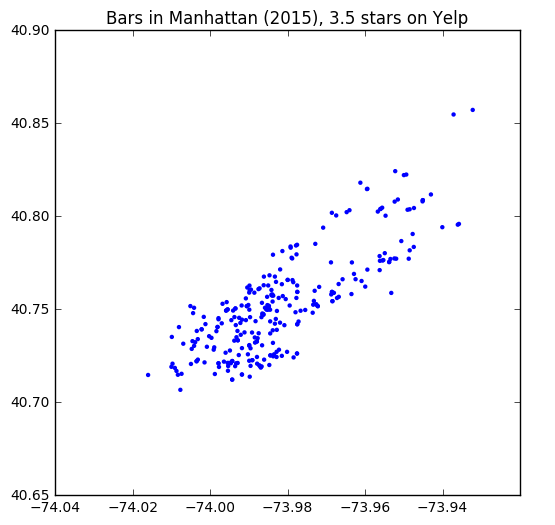

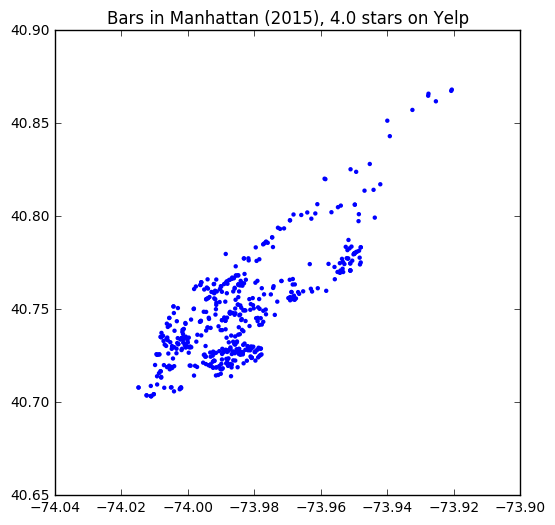

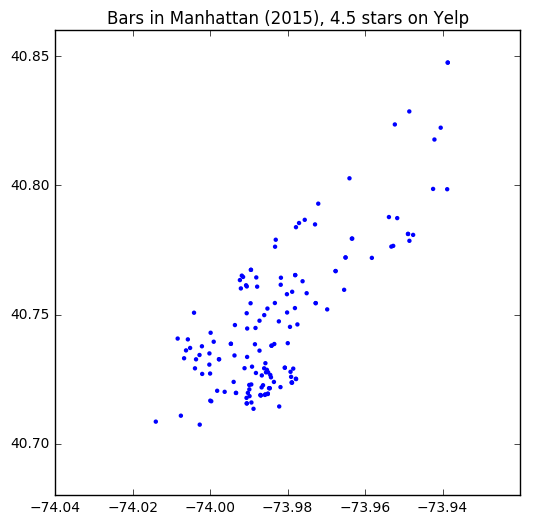

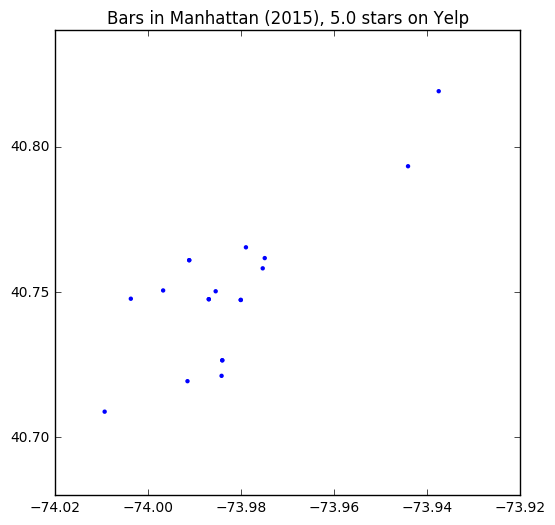

In [33]:
# separate maps for bars of each yelp rating

for stars in [3.0,3.5,4.0,4.5,5.0]:
    x,y = zip(*yelpdf[yelpdf.rating==stars].lat_long)
    z = yelpdf.rating


    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title('Bars in Manhattan (2015), ' + str(stars) + ' stars on Yelp')
    cax=ax.scatter(y, x, s=10, edgecolor='')
    plt.show()
    

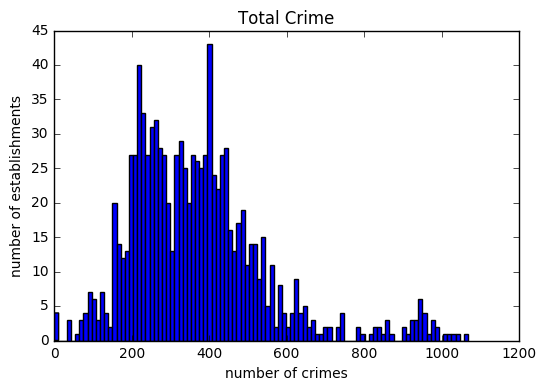

In [98]:
# show crime index histogram for all crimes

fig, ax = plt.subplots()
ax.set_title('Total Crime')
ax.set_xlabel('number of crimes')
ax.set_ylabel('number of establishments')

H = ax.hist(yelpcrimedf['TOT'], bins=100)


In [ ]:
# normalized data for crime index

In [21]:
yelpcrimedf['TOT_normalized']=(yelpcrimedf.TOT-mean(yelpcrimedf.TOT))/std(yelpcrimedf.TOT)

count    1.000000e+03
mean    -1.119105e-16
std      1.000500e+00
min     -2.078827e+00
25%     -7.146119e-01
50%     -1.227004e-01
75%      4.353875e-01
max      3.936121e+00
Name: TOT_normalized, dtype: float64

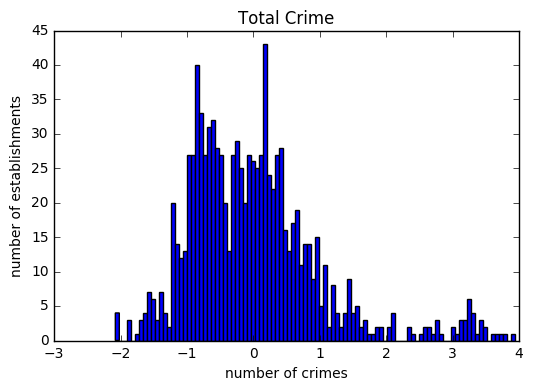

In [22]:
fig, ax = plt.subplots()
ax.set_title('Total Crime')
ax.set_xlabel('number of crimes')
ax.set_ylabel('number of establishments')

H = ax.hist(yelpcrimedf['TOT_normalized'], bins=100)

yelpcrimedf['TOT_normalized'].describe()

In [23]:
yelpcrimedf.sort('TOT', ascending=False).head(1)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,categories,deals,display_phone,distance,eat24_url,gift_certificates,id,image_url,is_claimed,is_closed,...,lat_long,BUR,ASS,LAR,GTA,MUR,RAP,ROB,TOT,TOT_normalized
368,"[Category(name='Irish', alias='irish'), Catego...",NaN,+1-212-629-6191,NaN,NaN,NaN,stout-nyc-new-york,https://s3-media3.fl.yelpcdn.com/bphoto/h5jZH6...,True,False,...,"(40.749863099999999, -73.989868000000001)",128,41,823,10,2,0,64,1068,3.936121


In [24]:
# summary stats for each crime index by type

yelpcrimedf[felony_ref.code].describe()

,BUR,ASS,LAR,GTA,MUR,RAP,ROB
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,40.875000,32.553000,251.316000,8.838000,0.367000,3.01400,32.803000
std,22.128512,18.173758,142.813767,4.064761,0.738144,5.56442,17.070723
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,26.000000,21.000000,151.000000,6.000000,0.000000,0.00000,21.000000
50%,39.000000,29.000000,230.000000,9.000000,0.000000,0.00000,30.000000
75%,52.000000,39.000000,307.500000,12.000000,0.000000,6.00000,42.250000
max,141.000000,108.000000,823.000000,21.000000,4.000000,31.00000,100.000000


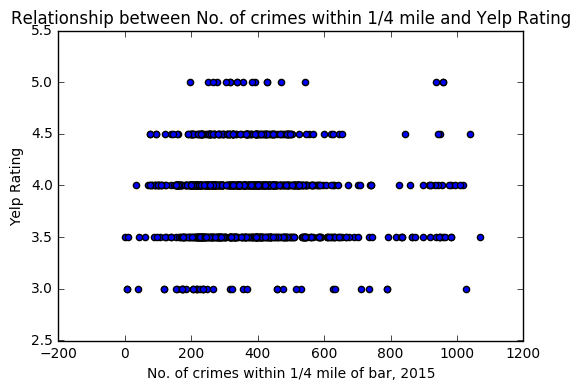

In [25]:
plt.scatter(yelpcrimedf.TOT, yelpcrimedf.rating)
plt.xlabel("No. of crimes within 1/4 mile of bar, 2015")
plt.ylabel("Yelp Rating")
plt.title("Relationship between No. of crimes within 1/4 mile and Yelp Rating")


In [26]:
from ast import literal_eval
literal_eval(yelpcrimedf.neighborhoods[1])

['Midtown West', "Hell's Kitchen"]

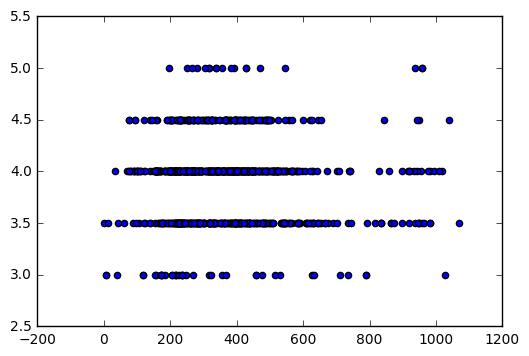

In [43]:
# scatterplot of crime score vs ratings

fig, ax = plt.subplots()
im = ax.scatter(yelpcrimedf['TOT'], yelpcrimedf['rating'])

In [45]:
from statsmodels.formula.api import ols

In [27]:
#standardized rating score
yelpcrimedf['rating_standardized']=(yelpcrimedf['rating']-mean(yelpcrimedf['rating']))/std(yelpcrimedf['rating'])

In [28]:
felony_ref.code + '_standardized'

0    BUR_standardized
1    ASS_standardized
2    LAR_standardized
3    GTA_standardized
4    MUR_standardized
5    RAP_standardized
6    ROB_standardized
Name: code, dtype: object

In [29]:
#create standardized columns for each felony

for ref in felony_ref.code:
    yelpcrimedf[ref+'_standardized']=(yelpcrimedf[ref]-mean(yelpcrimedf[ref]))/std(yelpcrimedf[ref])

In [128]:
m = ols('rating ~ BUR_standardized + ASS_standardized + LAR_standardized + GTA_standardized + MUR_standardized + RAP_standardized + ROB_standardized',yelpcrimedf).fit()
print(m.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.604
Date:                Mon, 19 Sep 2016   Prob (F-statistic):           0.000766
Time:                        16:21:31   Log-Likelihood:                -486.25
No. Observations:                1000   AIC:                             988.5
Df Residuals:                     992   BIC:                             1028.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            3.9150      0.012  

In [31]:
# create category aliases using Category data

category_alias_unpacker = lambda x: re.findall("alias='(\w+)'", x)

yelpcrimedf['cat_alias']=yelpcrimedf['categories'].apply(category_alias_unpacker)

In [32]:
#need a way to easily slice across categories

#build list of unique category aliases

unique_cat_alias=[]
for x in yelpcrimedf.cat_alias:
    for y in x:
        unique_cat_alias.append(y)
unique_cat_alias=pd.DataFrame({'cat_name':list(set(unique_cat_alias))})


In [34]:
# convert category to boolean table

cat_bool_map={}

for unique_cat in unique_cat_alias.cat_name:
    cat_bool_map[unique_cat]=[]

    for cat_entry in yelpcrimedf.cat_alias:
        cat_bool_map[unique_cat].append(unique_cat in cat_entry)

cat_bool_df=pd.DataFrame(cat_bool_map)

In [35]:
# top 10 subtypes of bars by count

cat_bool_df.sum().sort_values(ascending=False).head(10)

bars                278
cocktailbars        193
newamerican         190
lounges             155
pubs                142
wine_bars           134
tradamerican        119
sportsbars           79
divebars             59
breakfast_brunch     45
dtype: int64

In [133]:

# multivariate OLS for each of the top 10 types of bars vs standardized counts of felonies

for unique_cat in unique_cat_alias.cat_name:
    if sum(cat_bool_df[unique_cat]) > 44:
        
        df=yelpcrimedf[cat_bool_df[unique_cat]]
        print(unique_cat)
        m = ols('rating ~ BUR_standardized + ASS_standardized + LAR_standardized + GTA_standardized + MUR_standardized + RAP_standardized + ROB_standardized',df).fit()
        print(m.summary())
        
        

wine_bars
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7388
Date:                Mon, 19 Sep 2016   Prob (F-statistic):              0.640
Time:                        16:46:41   Log-Likelihood:                -25.159
No. Observations:                 134   AIC:                             66.32
Df Residuals:                     126   BIC:                             89.50
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.0962   